<a href="https://colab.research.google.com/github/Adhyanmishragit/ADHYANKISHU01/blob/main/Prediction_01_DVL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Install libraries (if needed; skip on Databricks, already installed)
%pip install pandas numpy scikit-learn xgboost lightgbm seaborn matplotlib

# Import core libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


In [2]:
# Set file paths
train_path = '/content/train.csv'
test_path = '/content/test.csv'

# Load data with error handling
try:
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    print("Data loaded successfully!")
except Exception as e:
    print(f"Error loading files: {e}")
    exit()


Data loaded successfully!


In [3]:
# Basic data exploration
print("\n=== Train Data Overview ===")
print(f"Shape: {train.shape}")
print(train.head())
print(train.dtypes)
print(train.isnull().sum())

print("\n=== Test Data Overview ===")
print(f"Shape: {test.shape}")
print(test.head())
print(test.dtypes)
print(test.isnull().sum())



=== Train Data Overview ===
Shape: (6091, 10)
   row_id  num_trips  month  day  hour day_of_week  temp  temp_wb  \
0       1      16714      1    1     0         Mon     9        7   
1       2      19041      1    1     1         Mon     9        7   
2       5       8739      1    1     4         Mon     8        6   
3       6       4229      1    1     5         Mon     7        5   
4       9       3643      1    1     8         Mon     8        6   

   rel_humidity  precipitation  
0            55            0.0  
1            55            0.0  
2            55            0.0  
3            57            0.0  
4            60            0.0  
row_id             int64
num_trips          int64
month              int64
day                int64
hour               int64
day_of_week       object
temp               int64
temp_wb            int64
rel_humidity       int64
precipitation    float64
dtype: object
row_id           0
num_trips        0
month            0
day              0


In [5]:
def create_features(df):
    numeric_cols = ['temp', 'precip', 'hour', 'day_of_week', 'month']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(df[col].mean())
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_rush_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 9)) | ((df['hour'] >= 16) & (df['hour'] <= 19))
    df['is_night'] = (df['hour'] <= 5) | (df['hour'] >= 20)
    if all(col in df.columns for col in ['temp', 'precip']):
        if pd.api.types.is_numeric_dtype(df['temp']) and pd.api.types.is_numeric_dtype(df['precip']):
            df['temp_precip_interaction'] = df['temp'] * df['precip']
    return df

# Apply feature engineering
train = create_features(train)
test = create_features(test)


In [7]:
# Ensure all features are numeric
non_numeric = [col for col in train.columns if not pd.api.types.is_numeric_dtype(train[col]) and col != 'row_id']
for col in non_numeric:
    train[col] = pd.to_numeric(train[col], errors='coerce')
    test[col] = pd.to_numeric(test[col], errors='coerce')

# Prepare data for modeling
X = train.drop(['row_id', 'num_trips'], axis=1)
y = train['num_trips']
X_test = test.drop(['row_id'], axis=1)

# Fill NA values
X = X.fillna(0)
X_test = X_test.fillna(X.mean())


In [8]:
tscv = TimeSeriesSplit(n_splits=5)
models = {
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42, n_jobs=-1),
    'LightGBM': LGBMRegressor(n_estimators=200, learning_rate=0.1, random_state=42, n_jobs=-1)
}
results = {}
for name, model in models.items():
    rmse_scores = []
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_scores.append(rmse)
        print(f"{name} Fold RMSE: {rmse:.2f}")
    results[name] = np.mean(rmse_scores)
    print(f"{name} - Average RMSE: {results[name]:.2f}")


RandomForest Fold RMSE: 3228.01
RandomForest Fold RMSE: 2910.32
RandomForest Fold RMSE: 2761.85
RandomForest Fold RMSE: 3551.82
RandomForest Fold RMSE: 3195.70
RandomForest - Average RMSE: 3129.54
XGBoost Fold RMSE: 3489.99
XGBoost Fold RMSE: 3245.30
XGBoost Fold RMSE: 2706.54
XGBoost Fold RMSE: 3626.02
XGBoost Fold RMSE: 3535.48
XGBoost - Average RMSE: 3320.67
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 310
[LightGBM] [Info] Number of data points in the train set: 1016, number of used features: 11
[LightGBM] [Info] Start training from score 12098.983268
LightGBM Fold RMSE: 3507.79
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 341
[Ligh

In [9]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    n_iter=10,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1)
search.fit(X, y)
print("Best params:", search.best_params_)


Best params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 30}


In [10]:
best_rf = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=4,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X, y)
final_preds = best_rf.predict(X_test)
submission = pd.DataFrame({
    'row_id': test['row_id'],
    'num_trips': np.round(final_preds).astype(int).clip(min=0)
})
# Change the output path to a location within the Colab environment
# For example, save it to the default content directory
output_path = '/content/naruto.csv'
submission.to_csv(output_path, index=False)
print(f"Submission file saved to: {output_path}")

Submission file saved to: /content/naruto.csv


In [11]:
import pandas as pd

# Load your submission file
submission = pd.read_csv('/content/naruto.csv')
display(submission)


,row_id,num_trips
0,3,3452
1,4,3857
2,7,4922
3,8,8097
4,10,10568
...,...,...
2606,8679,9339
2607,8682,2442
2608,8688,10029
2609,8689,10464


In [12]:
import pandas as pd
submission = pd.read_csv('/content/naruto.csv')
print(submission.head())
print(submission.columns)
print(submission.shape)


   row_id  num_trips
0       3       3452
1       4       3857
2       7       4922
3       8       8097
4      10      10568
Index(['row_id', 'num_trips'], dtype='object')
(2611, 2)


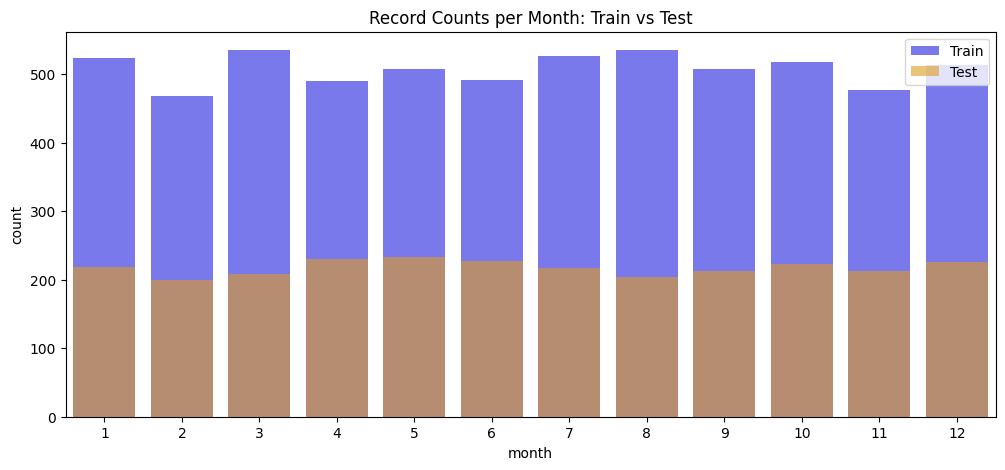

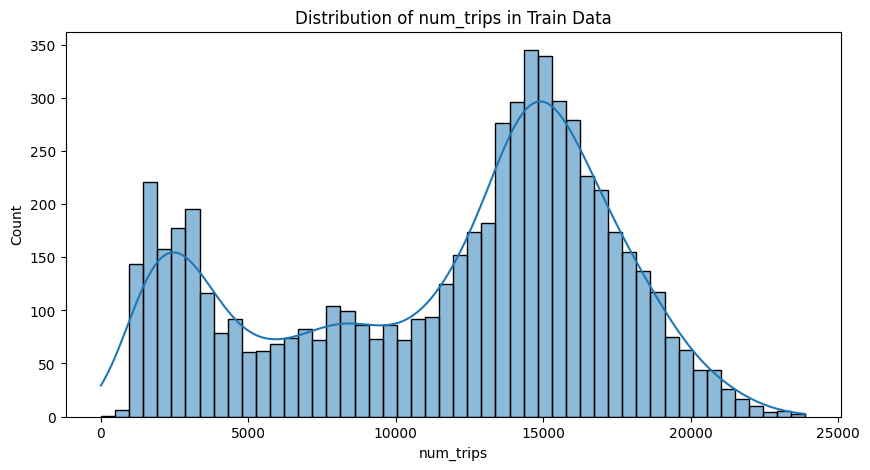

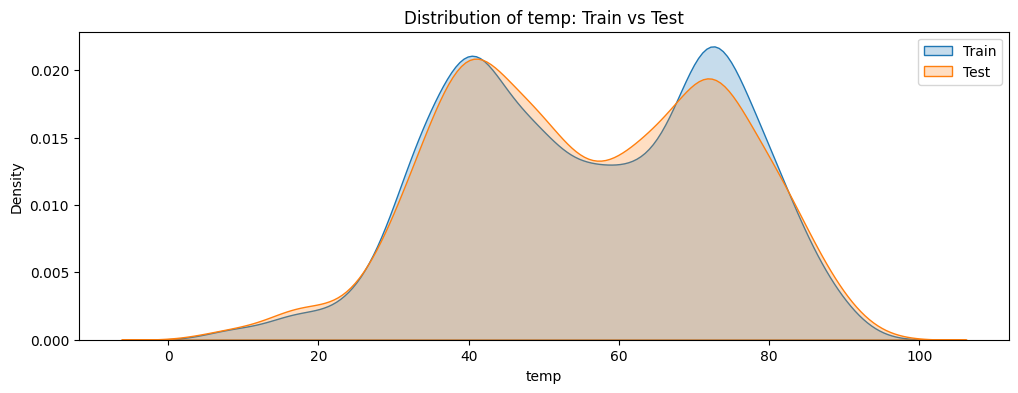

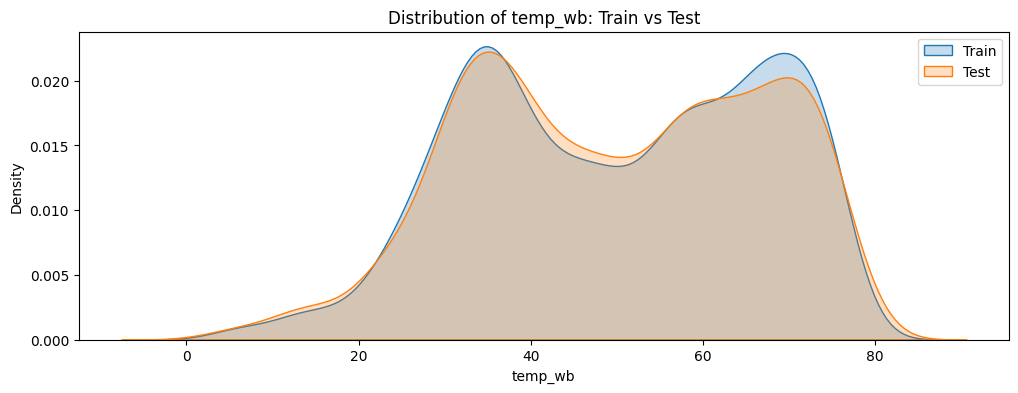

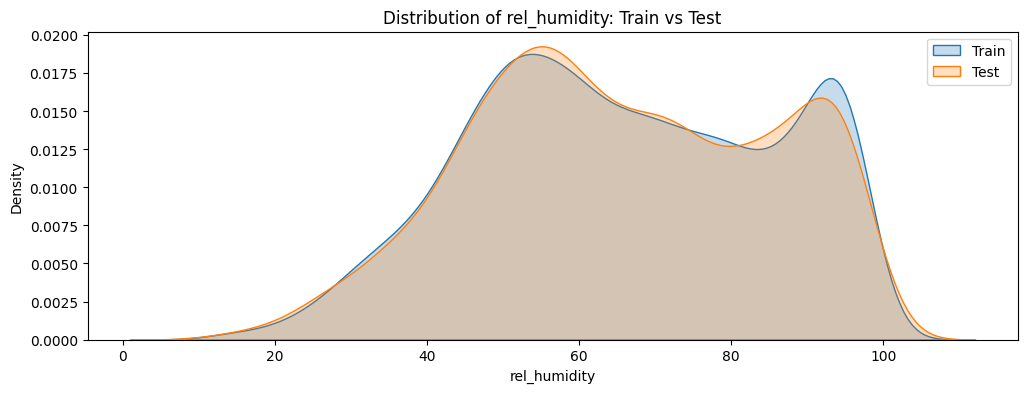

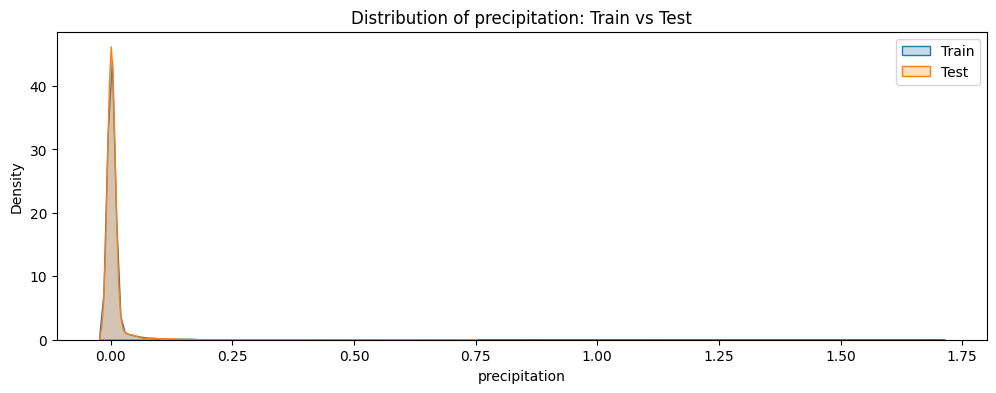

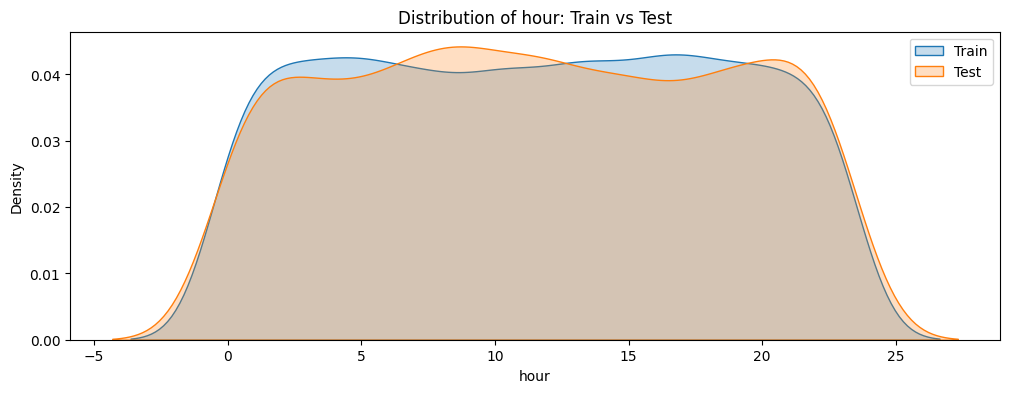

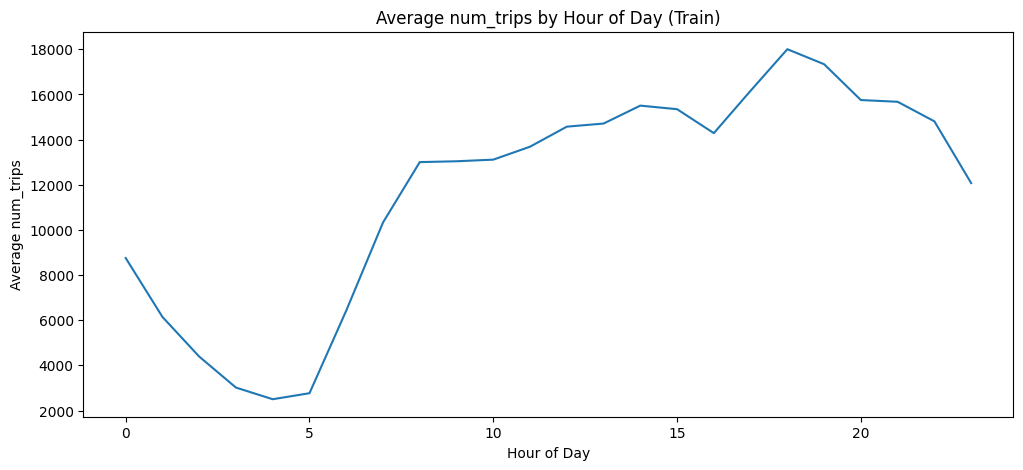

<ipython-input-13-1097389309>:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dow_avg = train.groupby('day_of_week')['num_trips'].mean().reindex(day_order)


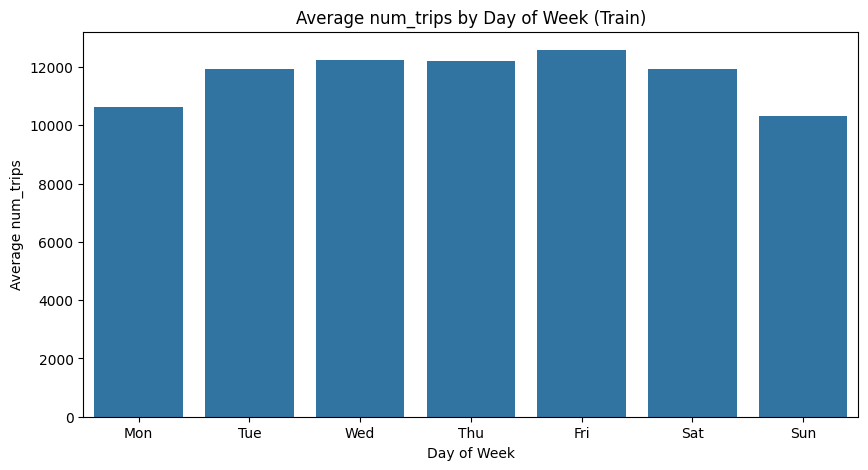

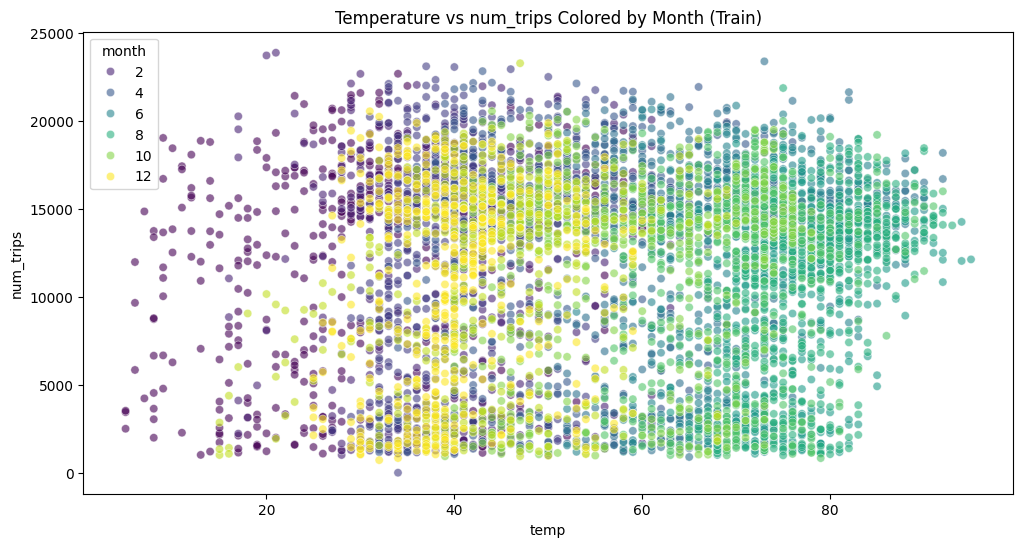

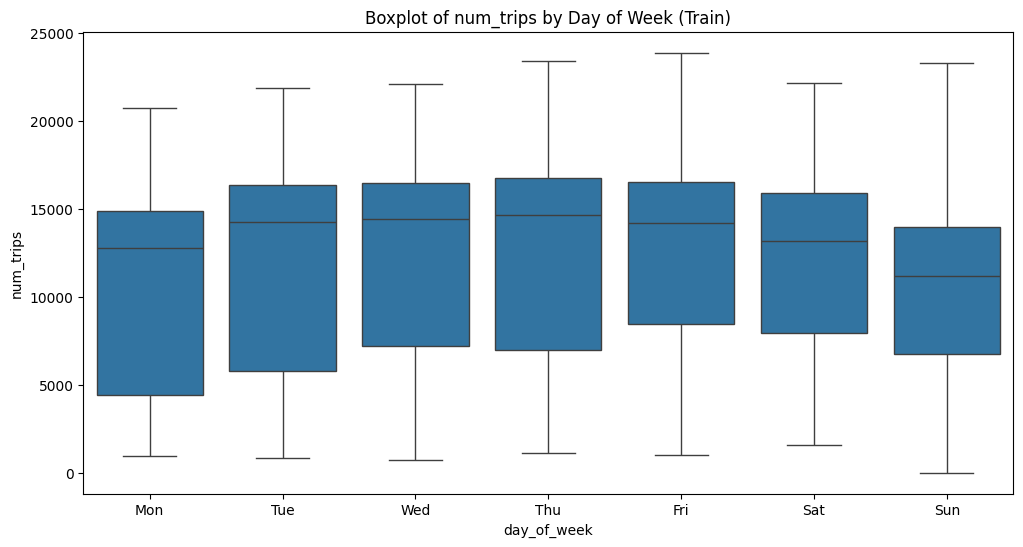

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train_path = '/content/train.csv'
test_path = '/content/test.csv'


train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# Convert day_of_week to categorical ordered type for better plotting
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
train['day_of_week'] = pd.Categorical(train['day_of_week'], categories=day_order, ordered=True)
test['day_of_week'] = pd.Categorical(test['day_of_week'], categories=day_order, ordered=True)

# 1. Time coverage: Plot counts of records per month in train vs test
plt.figure(figsize=(12,5))
sns.countplot(data=train, x='month', color='blue', alpha=0.6, label='Train')
sns.countplot(data=test, x='month', color='orange', alpha=0.6, label='Test')
plt.title('Record Counts per Month: Train vs Test')
plt.legend()
plt.show()

# 2. Distribution of target variable in train
plt.figure(figsize=(10,5))
sns.histplot(train['num_trips'], bins=50, kde=True)
plt.title('Distribution of num_trips in Train Data')
plt.xlabel('num_trips')
plt.show()

# 3. Distribution comparison of key numeric features in train and test
numeric_features = ['temp', 'temp_wb', 'rel_humidity', 'precipitation', 'hour']

for feature in numeric_features:
    plt.figure(figsize=(12,4))
    sns.kdeplot(train[feature], label='Train', fill=True)
    sns.kdeplot(test[feature], label='Test', fill=True)
    plt.title(f'Distribution of {feature}: Train vs Test')
    plt.legend()
    plt.show()

# 4. Average num_trips by hour of day (train only)
plt.figure(figsize=(12,5))
hourly_avg = train.groupby('hour')['num_trips'].mean()
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values)
plt.title('Average num_trips by Hour of Day (Train)')
plt.xlabel('Hour of Day')
plt.ylabel('Average num_trips')
plt.show()

# 5. Average num_trips by day of week (train only)
plt.figure(figsize=(10,5))
dow_avg = train.groupby('day_of_week')['num_trips'].mean().reindex(day_order)
sns.barplot(x=dow_avg.index, y=dow_avg.values)
plt.title('Average num_trips by Day of Week (Train)')
plt.xlabel('Day of Week')
plt.ylabel('Average num_trips')
plt.show()

# 6. Scatter plot: temp vs num_trips colored by month (train only)
plt.figure(figsize=(12,6))
sns.scatterplot(data=train, x='temp', y='num_trips', hue='month', palette='viridis', alpha=0.6)
plt.title('Temperature vs num_trips Colored by Month (Train)')
plt.show()

# 7. Boxplot: num_trips by day_of_week (train only)
plt.figure(figsize=(12,6))
sns.boxplot(data=train, x='day_of_week', y='num_trips', order=day_order)
plt.title('Boxplot of num_trips by Day of Week (Train)')
plt.show()
